## Portfolio Optimization using Python

#### References

Website: https://ryanoconnellfinance.com/python-portfolio-optimization/


### Imports


In [234]:
import os
from fredapi import Fred
import datetime
from datetime import datetime, timedelta
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
from dotenv import load_dotenv
import matplotlib.pyplot as plt

### Section 1: Define Tickers and Time Range

First, we define a list of tickers for the assets we want to include in the portfolio. In this example, we use five ETFs representing various asset classes: SPY, BND, GLD, QQQ, and VTI. We then set the start and end dates for our analysis. We use a five-year historical time range for our calculations.


In [235]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']
end_date = datetime.today()
start_date = end_date - timedelta(days=15*365)

### Section 2: Download Adjusted Close Prices

Next, we create an empty DataFrame to store the adjusted close prices of each asset. We use the yfinance library to download the data from Yahoo Finance.


In [236]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### Display the DataFrame


In [237]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2009-10-12   81.573570  51.633038  103.559998   37.181267   41.548485
2009-10-13   81.406929  51.672146  104.260002   37.190002   41.434357
2009-10-14   82.808395  51.450729  104.180000   37.696571   42.172478
2009-10-15   83.111435  51.463749  102.860001   37.609245   42.317062
2009-10-16   82.490242  51.483261  103.180000   37.364685   42.005077
...                ...        ...         ...         ...         ...
2024-10-01  568.619995  75.110001  245.610001  481.269989  280.579987
2024-10-02  568.859985  74.970001  245.660004  481.950012  280.640015
2024-10-03  567.820007  74.639999  245.490005  481.589996  280.040009
2024-10-04  572.979980  74.150002  245.000000  487.320007  282.750000
2024-10-07  571.520020  73.969902  244.770004  485.589996  281.882690

[3772 rows x 5 columns]


### Section 3: Calculate Lognormal Returns

We calculate the lognormal returns for each asset and drop any missing values.


In [238]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

#### Drop any missing values


In [239]:
log_returns = log_returns.dropna()

### Section 4: Calculate Covariance Matrix

We compute the covariance matrix using the annualized log returns.


In [240]:
cov_matrix = log_returns.cov() * 252

#### Display the covariance matrix


In [241]:
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.029385 -0.000003  0.001617  0.032568  0.029996
BND -0.000003  0.002326  0.002238  0.000212  0.000045
GLD  0.001617  0.002238  0.024351  0.001899  0.001765
QQQ  0.032568  0.000212  0.001899  0.041885  0.033262
VTI  0.029996  0.000045  0.001765  0.033262  0.030867


### Section 5: Define Portfolio Performance Metrics

We define functions to calculate the portfolio standard deviation, expected return, and Sharpe ratio.


#### Calculate the standard deviation


In [242]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

#### Calculate the expected return

\*Key assumption expected returns are based on historical returns


In [243]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

#### Calculate the Sharpe Ratio


In [244]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

### Section 6: Portfolio Optimization

We set the risk-free rate, define a function to minimize the negative Sharpe ratio, and set constraints and bounds for the optimization process.


#### Set risk-free rate


In [245]:
load_dotenv()
api_key = os.getenv('FRED_API_KEY')


fred = Fred(api_key='660c16cacffd83ac379574f4c42bf33e')

ten_year_treasury_rate = fred.get_series_latest_release('DGS10')/100
risk_free_rate = ten_year_treasury_rate.iloc[-1]


print(risk_free_rate)

0.0385


#### Set the constraints and bounds

Constraints are conditions that must be met by the solution during the optimization process. In this case, the constraint is that the sum of all portfolio weights must be equal to 1. The constraints variable is a dictionary with two keys: 'type' and 'fun'. 'type' is set to 'eq' which means 'equality constraint', and 'fun' is assigned the function check_sum, which checks if the sum of the portfolio equals 1.


In [246]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)


constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0.1, 0.6) for _ in range(len(tickers))]

#### Set the initial wights


In [247]:
initial_weights = np.array([1/len(tickers)]*len(tickers))

print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


#### Optimize the weights to maximize the Sharpe Ratio

'SLSQP' stands for sequential least squares quadratic programming, which is a numerical optimization technique suitable for solving nonlinear optimization problems with constraints.


In [248]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(
    log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

#### Set the optimal weights


In [249]:
optimal_weights = optimized_results.x

print(optimal_weights)

[0.1 0.1 0.1 0.6 0.1]


### Section 7: Analyze the Optimal Portfolio

We obtain the optimal weights and calculate the expected annual return, expected volatility, and Sharpe ratio for the optimal portfolio.


In [250]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.1000
BND: 0.1000
GLD: 0.1000
QQQ: 0.6000
VTI: 0.1000
Expected Annual Return: 0.1370
Expected Volatility: 0.1575
Sharpe Ratio: 0.6252


#### Display the final portfolio in a plot

We create a bar chart to visualize the optimal weights of the assets in the portfolio.


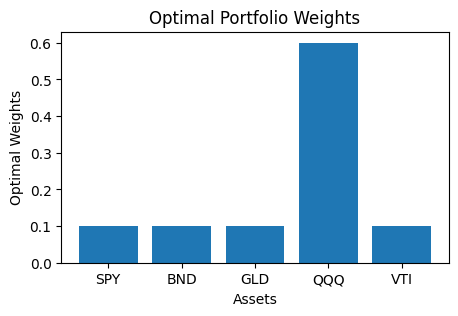

In [251]:
plt.figure(figsize=(5, 3))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

### Conclusion

This Python script demonstrates how to use Modern Portfolio Theory to optimize a portfolio of stocks. By calculating the optimal weights for each asset, we aim to maximize the Sharpe ratio, providing the highest possible risk-adjusted return. This approach can help investors create a well-diversified portfolio and make informed decisions when allocating their investments.
